In [1]:
import pystac_client
import planetary_computer
import rioxarray as rio
import xarray as xr
import geopandas as gpd
from shapely.geometry import shape
from shapely import Point, MultiPoint
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches as mpatches
import matplotlib.patheffects as path_effects
from matplotlib import colors
import numpy as np
import xrspatial as xrs
import cartopy.crs as ccrs
plt.rcParams['font.family'] = 'DejaVu Sans Mono'

In [2]:
# area of interest (Laguna del Carbón, Santa Cruz Province, Argentina)
# drawn in geojson.io
aoi = shape({"coordinates": [[
            [-69.24378724505196,-49.087771257260314],
            [-69.24378724505196,-49.853443345714254],
            [-67.73558451751929,-49.853443345714254],
            [-67.73558451751929,-49.087771257260314],
            [-69.24378724505196,-49.087771257260314]]
        ],"type": "Polygon"})

# get UTM projection
aoi_series = gpd.GeoSeries([aoi], crs=4326)
prj = ccrs.epsg(aoi_series.estimate_utm_crs().to_epsg())

# get country outlines form natural earth and reproject
for_inset = (gpd.read_file(
    gpd.datasets.get_path('naturalearth_lowres'),
    where="continent in ('North America', 'South America')"
    ).cx[-90:-40,-80:10]).to_crs(prj)

C:\Users\s1759665\AppData\Local\Temp\ipykernel_22308\1138618841.py:17: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  gpd.datasets.get_path('naturalearth_lowres'),


In [3]:
## get contours in aoi from copernicus global DEM hosted on planetary computer
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace)

search = catalog.search(collections=['cop-dem-glo-30'],
                        intersects=aoi)
items = list(search.get_items())

# if aoi crosses multiple DEM tiles stitch 'em together
if len(items) > 1:
    data = []
    for item in items:
        signed_asset = planetary_computer.sign(item.assets["data"])
        with rio.open_rasterio(signed_asset.href) as f:
            data.append(f.squeeze().drop("band").rename('z'))
    dem = ((xr.merge(data))
           .rio.set_crs(4326)
           .rio.write_transform()
           .rio.clip_box(*aoi.bounds)
           .rio.write_transform())
else:
    signed_asset = planetary_computer.sign(items[0].assets["data"])
    dem =  (rio.open_rasterio(signed_asset.href)
            .squeeze()
            .rio.set_crs(4326)
            .rio.write_transform()
            .rio.clip_box(*aoi.bounds)
            .rio.write_transform())

# reproject to local utm crs
dem_prj = dem.rio.reproject(prj, resolution=50, nodata=np.nan)
hillshade = xrs.hillshade(dem_prj['z'])

### find lowest point
# this doesn't quite work
# inds = dem_prj['z'].argmin(dim=['x','y'])
# lo_p = Point(dem_prj['z'][inds].x,
#              dem_prj['z'][inds].y)

# because of 30 m DEM resolution the lowest point (above) doesn't quite tally 
# with where it should be...so

### so instead:
## get all grid points that are <= 105, and compute their centroid
is_minimum = xr.where(dem_prj['z'] <= -105, 1, 0).values.flatten()
X,Y = np.meshgrid(dem_prj['x'], dem_prj['y'])
X = X.flatten()
Y = Y.flatten()
mp = MultiPoint([Point(x,y) for x,y in list(zip(X[is_minimum==1], Y[is_minimum==1]))])
lo_p = mp.centroid

# make normalization for colormap
vmin=dem_prj['z'].min().values
vmax=dem_prj['z'].max().values
divnorm=colors.TwoSlopeNorm(vmin=vmin, vcenter=0., vmax=vmax)

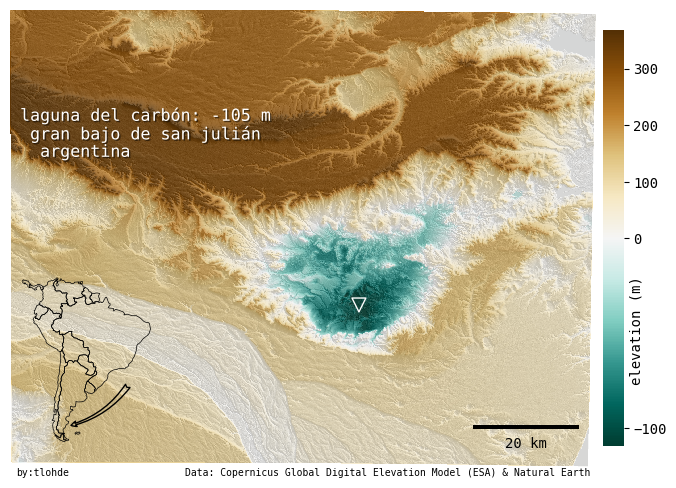

In [4]:
fig,ax=plt.subplots(figsize=[9,9], subplot_kw={'projection':prj})

# plot elevation
dem_prj['z'].plot(cmap='BrBG_r',
                  norm=divnorm,
                  cbar_kwargs={'label':'elevation (m)',
                               'shrink':0.6,
                               'pad':0.01},
                  ax=ax)

# hill shade
hillshade.plot(cmap='Greys',
               add_colorbar=False,
               alpha=0.2,
               ax=ax)

## lowest point
ax.scatter(lo_p.x, lo_p.y,
           fc='none', ec='w',
           s=100, marker='v',)

ax.add_artist(ScaleBar(dx=1, location='lower right', box_alpha=0, border_pad=1))

### add inset axes
inset = fig.add_axes([0.11,0.26,0.2,0.2])
for_inset.plot(fc='none', ec='k',
              linewidth=0.5, ax=inset)

### you are here arrow
el = mpatches.Ellipse((lo_p.x, lo_p.y),
                      0.3, 0.4,
                      angle=100, alpha=1)
inset.annotate("", xy=(lo_p.x, lo_p.y), xycoords='data',
               xytext=(lo_p.x+3000000, lo_p.y+2000000), textcoords='data',
               arrowprops=dict(arrowstyle="fancy",
                               fc= 'none', ec='k',
                               patchB=el, shrinkB=5,
                               connectionstyle="arc3, rad=-0.2"))
inset.set_aspect('equal')
inset.set_axis_off()
#####################
# move colorbar label into the gap
fig.axes[1].yaxis.set_label_coords(x=1.3,y=0.28)

# remove colorbar outline
ax.collections[0].colorbar.outline.set_visible(False)

ax.set_axis_off()
ax.set_title(None)
ax.set_title(' laguna del carbón: -105 m\n  gran bajo de san julián\n   argentina',
             ha='left', loc='left',
             y=0.66, c='w',
             path_effects=[path_effects.withSimplePatchShadow(shadow_rgbFace='k',
                                                              alpha=0.5,
                                                              offset=(1,-1))])

ax.annotate(text='Data: Copernicus Global Digital Elevation Model (ESA) & Natural Earth',
            xy=(0.99,-0.02), 
            xycoords='axes fraction', 
            ha='right',
            c='k', 
            fontsize=7,
            font='DejaVu Sans Mono')

ax.annotate(text='by:tlohde',
            xy=(0.01,-0.02), 
            xycoords='axes fraction',
            ha='left',
            fontsize=7,
            font='DejaVu Sans Mono');

In [5]:
fig.savefig('day12.png', bbox_inches='tight', dpi=300)